In [222]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
import json
from dotenv import load_dotenv
from googleapiclient.discovery import build

In [4]:
# get the API key from the .env file
load_dotenv()
api_key = os.getenv('API_KEY')

In [6]:
# initiate the YouTube client
youtube = build(serviceName='youtube', version='v3', developerKey=api_key)

In [8]:
videoId = 'x3SZsSWqS3g'

In [10]:
request = youtube.commentThreads().list(part='snippet',
                                  videoId=videoId,
                                  textFormat='plainText')

response = request.execute()

In [12]:
def get_comments(response):
    comments = []
    if response['kind'] == 'youtube#commentThreadListResponse':
        for item in response['items']:
            comment_snippet = item['snippet']['topLevelComment']['snippet']
            comment_details = {'comment': comment_snippet['textOriginal'],
                               'comment_id': item['snippet']['topLevelComment']['id'],
                               'parent_comment': None,
                               'user': comment_snippet['authorDisplayName'],
                               'user_avatar': comment_snippet['authorProfileImageUrl'],
                               'user_page': comment_snippet['authorChannelUrl'],
                               'comment_time': comment_snippet['publishedAt'],
                               'likes': comment_snippet['likeCount'],
                               'replies': item['snippet']['totalReplyCount']}

            comments.append(comment_details)
            
    elif response['kind'] == 'youtube#commentListResponse':
        for item in response['items']:
            comment_snippet = item['snippet']
            comment_details = {'comment': comment_snippet['textOriginal'],
                               'comment_id': item['id'],
                               'parent_comment': comment_snippet['parentId'],
                               'user': comment_snippet['authorDisplayName'],
                               'user_avatar': comment_snippet['authorProfileImageUrl'],
                               'user_page': comment_snippet['authorChannelUrl'],
                               'comment_time': comment_snippet['publishedAt'],
                               'likes': comment_snippet['likeCount'],
                               'replies': None}

            comments.append(comment_details)
            
    return comments

In [16]:
comments = []

comments += get_comments(response)

while 'nextPageToken' in response.keys():
    nextPageToken = response['nextPageToken']
    request = youtube.commentThreads().list(part='snippet', videoId=videoId, pageToken=nextPageToken, textFormat='plainText')
    response = request.execute()
    
    comments += get_comments(response)

In [18]:
comments

[{'comment': 'spot on sarr tank you',
  'comment_id': 'UgyptLZU6sOxVn328FN4AaABAg',
  'parent_comment': None,
  'user': '@ugly_indian_scammer_',
  'user_avatar': 'https://yt3.ggpht.com/YgIAPldF-wv5zqTjxAlkDGSxQh2itnM30kD0AChgZ035rooYhe_SslkGHlduzn5HRe8ffdXvpME=s48-c-k-c0x00ffffff-no-rj',
  'user_page': 'http://www.youtube.com/@ugly_indian_scammer_',
  'comment_time': '2024-04-27T19:07:36Z',
  'likes': 0,
  'replies': 0},
 {'comment': 'SAAAAAAAAAAAAAAAAAAAAAAAR',
  'comment_id': 'UgwSA4uvZj9G1HsZx3Z4AaABAg',
  'parent_comment': None,
  'user': '@frankw3678',
  'user_avatar': 'https://yt3.ggpht.com/ytc/AIdro_mn6vzRsus9QLBjKpGITterC42xMlpBSHIpK8-NhYs=s48-c-k-c0x00ffffff-no-rj',
  'user_page': 'http://www.youtube.com/@frankw3678',
  'comment_time': '2024-04-26T16:03:34Z',
  'likes': 0,
  'replies': 0},
 {'comment': 'So that’s what pajeet means. I just learned about that word.',
  'comment_id': 'UgyPGcQs55TMbh1ImNV4AaABAg',
  'parent_comment': None,
  'user': '@XGen_23',
  'user_avatar': 'h

In [20]:
len(comments)

172

In [22]:
replies = []

for comment in comments:
    if comment['replies'] > 0:
        request = youtube.comments().list(part='snippet', parentId=comment['comment_id'], textFormat='plainText')
        response = request.execute()
        
        replies += get_comments(response)
        
        while 'nextPageToken' in response.keys():
            nextPageToken = response['nextPageToken']
            request = youtube.comments().list(part='snippet', parentId=comment['comment_id'], pageToken=nextPageToken, textFormat='plainText')
            response = request.execute()

            replies += get_comments(response)

In [24]:
replies

[{'comment': 'No Saaar Time extended....now Amrit Kaaal 2047 Saaaar',
  'comment_id': 'Ugx_SSNHjNehar3Rfad4AaABAg.A2YWe79VHBZA2Zb61hVonQ',
  'parent_comment': 'Ugx_SSNHjNehar3Rfad4AaABAg',
  'user': '@fettuccine794',
  'user_avatar': 'https://yt3.ggpht.com/KFX1Bs0oadEAWQ4zGlKwgA-k7JUQ5L4LoN1-3UfjvFkokPPX8NYVOztm2oWV7lYtc4wZMd9S=s48-c-k-c0x00ffffff-no-rj',
  'user_page': 'http://www.youtube.com/@fettuccine794',
  'comment_time': '2024-04-23T07:16:16Z',
  'likes': 0,
  'replies': None},
 {'comment': 'HAHAHAHHAA ENDIA SUBERPOWER SAAAAAAR!!!',
  'comment_id': 'Ugxb0mG7JyhXIWI0iEx4AaABAg.A2R5CBcKKDhA2RILVgTMc2',
  'parent_comment': 'Ugxb0mG7JyhXIWI0iEx4AaABAg',
  'user': '@joste77',
  'user_avatar': 'https://yt3.ggpht.com/ytc/AIdro_mQNaXLJk6SoRU9w5S4YV68X40poU8EjScw6hojiUy5Qj8=s48-c-k-c0x00ffffff-no-rj',
  'user_page': 'http://www.youtube.com/@joste77',
  'comment_time': '2024-04-20T01:49:41Z',
  'likes': 1,
  'replies': None},
 {'comment': "That's why Ms are riding boats in the Atlantic Oc

In [26]:
len(replies)

557

In [28]:
all_comments = comments + replies

In [30]:
len(all_comments)

729

In [32]:
all_comments_df = pd.DataFrame(all_comments)

In [34]:
all_comments_df

,comment,comment_id,parent_comment,user,user_avatar,user_page,comment_time,likes,replies
0,spot on sarr tank you,UgyptLZU6sOxVn328FN4AaABAg,None,@ugly_indian_scammer_,https://yt3.ggpht.com/YgIAPldF-wv5zqTjxAlkDGSx...,http://www.youtube.com/@ugly_indian_scammer_,2024-04-27T19:07:36Z,0,0.0
1,SAAAAAAAAAAAAAAAAAAAAAAAR,UgwSA4uvZj9G1HsZx3Z4AaABAg,None,@frankw3678,https://yt3.ggpht.com/ytc/AIdro_mn6vzRsus9QLBj...,http://www.youtube.com/@frankw3678,2024-04-26T16:03:34Z,0,0.0
2,So that’s what pajeet means. I just learned ab...,UgyPGcQs55TMbh1ImNV4AaABAg,None,@XGen_23,https://yt3.ggpht.com/8VaDX_Wgy15JoylXTaEFUqkY...,http://www.youtube.com/@XGen_23,2024-04-26T15:08:35Z,0,0.0
3,Guys don't ever disable the comments section. ...,UgxhMwJ6rGoEXFKWmDR4AaABAg,None,@uselesshero.official,https://yt3.ggpht.com/ytc/AIdro_nabVw9bTnnDdEQ...,http://www.youtube.com/@uselesshero.official,2024-04-26T06:00:10Z,0,0.0
4,Phull saport saar.... 🇮🇱❤🇮🇳,Ugz1MgMZDYmrEkP2pA54AaABAg,None,@vincemacalacad8702,https://yt3.ggpht.com/2aHagrE3Iz2S-7T9er7nNGVg...,http://www.youtube.com/@vincemacalacad8702,2024-04-25T14:45:07Z,1,0.0
...,...,...,...,...,...,...,...,...,...
724,@@poolbadshah4948 toh beta woh aise kaam hi k...,UgzyAGDt7HEXd91TIu94AaABAg.9xjppUL6AK_A-OGbF4-mJN,UgzyAGDt7HEXd91TIu94AaABAg,@B.E.Y.O.N.D.,https://yt3.ggpht.com/qorHq0v_QYpquw-aS0Fn_JKI...,http://www.youtube.com/@B.E.Y.O.N.D.,2024-02-04T08:02:36Z,0,NaN
725,@@notwhoyouthink2415quite Pedo lover,UgzyAGDt7HEXd91TIu94AaABAg.9xjppUL6AK_A-dy5-ZeRVn,UgzyAGDt7HEXd91TIu94AaABAg,@Argon369,https://yt3.ggpht.com/tBYDUTcjmluS59xSpQKbSa1r...,http://www.youtube.com/@Argon369,2024-02-10T19:39:07Z,0,NaN
726,@@poolbadshah4948I’m pretty sure this was star...,UgzyAGDt7HEXd91TIu94AaABAg.9xjppUL6AK_A18-blIMtUS,UgzyAGDt7HEXd91TIu94AaABAg,@Frosty_V0,https://yt3.ggpht.com/1hhf3-NxR2CJd564V50twpQB...,http://www.youtube.com/@Frosty_V0,2024-03-18T17:29:04Z,0,NaN
727,yes saaar... VIKRAMADITYA EMPIRE RULE THE WORL...,UgzyAGDt7HEXd91TIu94AaABAg.9xjppUL6AK_A1OBNDPS7Yt,UgzyAGDt7HEXd91TIu94AaABAg,@themanofachild1546,https://yt3.ggpht.com/ytc/AIdro_lobEygh6O_Bjl7...,http://www.youtube.com/@themanofachild1546,2024-03-25T00:19:39Z,1,NaN


In [68]:
all_comments_df['comment_time'] = pd.to_datetime(all_comments_df['comment_time'])

In [52]:
all_comments_df['replies'].fillna(value=0, inplace=True)

In [64]:
all_comments_df = all_comments_df.astype({'likes': 'int32', 'replies': 'int32'})

In [38]:
all_comments_df['user'].value_counts()

user
@asingha94                 181
@Vic67s                     38
@rexk                       36
@RyzenRTX89                 19
@SuarPutrRaam-ShivGandu     11
                          ... 
@jumbochvk                   1
@user-ib6km8kh7f             1
@garrys3312                  1
@frankw3678                  1
@alive69times                1
Name: count, Length: 254, dtype: int64

In [164]:
all_comments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729 entries, 0 to 728
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   comment         729 non-null    object             
 1   comment_id      729 non-null    object             
 2   parent_comment  557 non-null    object             
 3   user            729 non-null    object             
 4   user_avatar     729 non-null    object             
 5   user_page       729 non-null    object             
 6   comment_time    729 non-null    datetime64[ns, UTC]
 7   likes           729 non-null    int32              
 8   replies         729 non-null    int32              
dtypes: datetime64[ns, UTC](1), int32(2), object(6)
memory usage: 45.7+ KB


In [308]:
def user_details(username, comments_df):
    user_comments = comments_df[comments_df['user'] == username].drop('user', axis=1)
    comments_per_hour = pd.DataFrame({'comment_time': range(24)})
    
    user_comments_per_hour = user_comments.groupby(all_comments_df['comment_time'].dt.hour).count()['comment'].reset_index()
    
    comments_per_hour = pd.merge(comments_per_hour, user_comments_per_hour, on='comment_time', how='outer').fillna(value=0)
    
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
    sns.barplot(comments_per_hour, x='comment_time', y='comment')
    ax.set(xlabel = 'Hour of Day', ylabel='Number of Comments', title='Number of Comments Per Hour of Day')
    ax.set_yticks(range(0,51,5))
    plt.show()

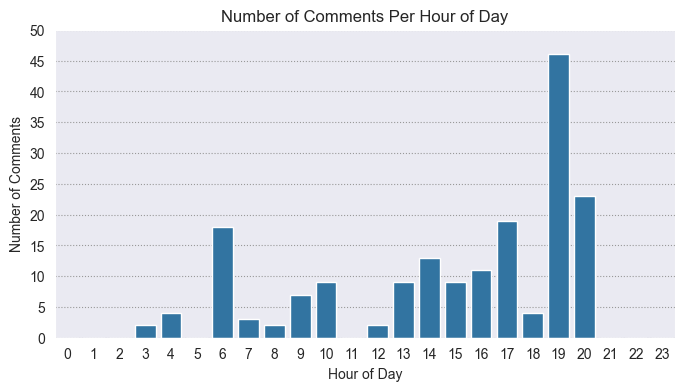

In [310]:
user_details('@asingha94', all_comments_df)

In [314]:
all_comments_df.to_csv('../data/comments.csv', index=None)